In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The top-level PyTorch package and tensor library
import torch 

# A subpackage that contains modules and extensible 
# classes for building neural networks. 
import torch.nn as nn

# A subpackage that contains standard optimization 
# operations like SGD and Adam. 
import torch.optim as optim

# A functional interface that contains typical operations 
# used for building neural networks like loss functions 
# and convolutions. 
import torch.nn.functional as F

from tqdm import tqdm # progress meter
import flows as fnn # imports the module flows.py, which you have in this directory

# Create data 

In [2]:
mu, sigma = 0, np.array([0.1,0.2,0.5]) # mean and standard deviation
pts = 10000 # number of data points

def p(i):
    rand = np.random.normal(mu, sigma[i], pts)
    stack = np.dstack((rand, sigma[i]*np.ones(len(rand))))
    return stack.reshape(-1,2)

#vecp = np.vectorize(p) THIS DOES NOT WORK pga ORDER OF OPERATIONS

datan = np.vstack((p(0),p(1),p(2)))

print(np.shape(datan))

(30000, 2)


## Plot data 

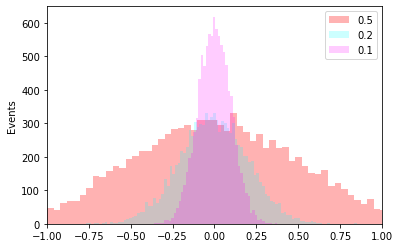

In [3]:
plt.hist(datan[20000:30000,0], bins = 100, fc=(1, 0, 0, 0.5), alpha=0.3, label='0.5')
plt.hist(datan[10000:20000,0], bins = 100, fc=(0, 1, 1, 0.5), alpha=0.2, label='0.2')
plt.hist(datan[:10000,0], bins = 50, fc=(1, 0, 1, 0.5), alpha=0.2, label='0.1')
plt.xlim(-1,1)
plt.legend(loc='upper right')
plt.ylabel('Events')
plt.show()

## Pre-process data 

In [4]:
'''Indices and shuffling'''

# Create an array of indices, of length data, and shuffle it
indices = np.array(range(len(datan))).astype('int') 
np.random.shuffle(indices)
# print(indices[:10],len(indices)) -- ok it works

datan = datan[indices] 
# print(datan[:10]) -- ok it works


In [5]:
''' Data Sets and Data Loaders'''

batch_size = 256

labels = torch.from_numpy(datan[:,1:2])
prob_data = torch.from_numpy(datan[:,0:1])

dataset = torch.utils.data.TensorDataset(prob_data, labels)
# Compared to anode: 
# The first argument is x (probably density data) and the second 
# is mjj (conditioned data)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True)

num_inputs = prob_data.shape[-1]
num_cond_inputs = labels.shape[-1]

# Define and train the model

In [6]:
''' ====================================================================== '''
''' model parameters '''
''' ====================================================================== '''

flow='maf' # MAF is what is being used in the training
batch_size = 256
test_batch_size = 10*batch_size
num_blocks = 15
num_hidden = 128
lr = 1e-4 # I assume this is learning rate

print('MAF pars',num_blocks,num_hidden)

CUDA = False #CUDA is a parallel computing platform and application programming interface model created by Nvidia. It allows software developers and software engineers to use a CUDA-enabled graphics processing unit for general purpose processing
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}

MAF pars 15 128


In [7]:
''' ====================================================================== '''
''' define training function '''
''' ====================================================================== '''

global_step = 0

def train(epoch):
    global global_step
    model.train() 
    train_loss = 0

    # make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable)
    pbar = tqdm(total=len(loader.dataset)) 
    
    for batch_idx, data in enumerate(loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float() # Assigns the 2nd element in data as the conditioned data
                cond_data = cond_data.to(device) # Sends conditioned data to the GPU
            else:
                cond_data = None

            data = data[0] # Assigns the 1st element in data as the data points
        data = data.to(device) # Sends the data to the GPU

        optimizer.zero_grad() # need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # print(data, cond_data)
        loss = -model.log_probs(data, cond_data).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pbar.update(data.size(0))
        pbar.set_description('Train, Log likelihood in nats: {:.6f}'.format(
            -train_loss / (batch_idx + 1)))

        global_step += 1

    pbar.close()

    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 0

    # The with statement itself ensures proper acquisition and release of resources.        
    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
    with torch.no_grad(): 
        model(loader.dataset.tensors[0].to(data.device),
            loader.dataset.tensors[1].to(data.device).float())

    # If you want to recursively iterate over modules, then you want to use .modules()    
    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 1

In [ ]:
''' ====================================================================== '''
''' Define model '''
''' ====================================================================== '''

act = 'relu'

modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs)
    ]

model = fnn.FlowSequential(*modules)
for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
model.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)



In [ ]:
''' ====================================================================== '''
''' Train model '''
''' ====================================================================== '''

epochs = 3

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train(epoch)
    torch.save(model.state_dict(),modellen+"_"+label+"_epoch_"+str(epoch)+".par")


Save the model to use it yourself for inference: You save the model, you restore it, and then you change the model to evaluation mode. This is done because you usually have BatchNorm and Dropout layers that by default are in train mode on construction:

torch.save(model.state_dict(), filepath)

#Later to restore:

model.load_state_dict(torch.load(filepath))

model.eval()

https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

Du använder filepath=modellen

# Old things I've tried 

In [99]:
''' Create data '''

mu, sigma = 0, np.array([0.1,0.2,0.5]) # mean and standard deviation
print(mu,sigma)

def p(s):
    rand = np.random.normal(mu, s, 10)
    #return np.dstack((rand, s*np.ones(len(rand))))
    #return np.array([rand,s],dtype = np.float32)
    #return np.append(rand,s)
    #ret = np.array([rand,s])
    return np.shape(rand)

'''def p(s):
    def pp(k):
        rand = np.random.normal(mu, k, 10)
        return np.dstack((rand, k*np.ones(len(rand))))
    #return np.array([rand,s],dtype = np.float32)
    #return np.append(rand,s)
    #ret = np.array([rand,s])
    #return np.shape(rand)
    return pp(s)'''

vecp = np.vectorize(p)

data = vecp(sigma)

print(data)

0 [0.1 0.2 0.5]


ValueError: setting an array element with a sequence.